### Code walkthrough

#### Predict car price based on features

**Note**: **instructor can move quickly throught EDA code, without getting in detail**

#### 1. Data Understanding and Exploration

Let's first have a look at the dataset and understand the size, attribute names etc.

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

import os

# hide warnings
import warnings
warnings.filterwarnings('ignore')

In [11]:
!pip install -U gdown

In [12]:
!gdown  1Zim4ODFec7nQqx5W_l8XzwzC_IB-3rmq

Downloading...
From: https://drive.google.com/uc?id=1Zim4ODFec7nQqx5W_l8XzwzC_IB-3rmq
To: /content/CarPrice_Assignment.csv
100% 26.7k/26.7k [00:00<00:00, 64.0MB/s]


In [13]:
# reading the dataset
cars = pd.read_csv("CarPrice_Assignment.csv")

In [14]:
# summary of the dataset: 205 rows, 26 columns, no null values
print(cars.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   CarName           205 non-null    object 
 3   fueltype          205 non-null    object 
 4   aspiration        205 non-null    object 
 5   doornumber        205 non-null    object 
 6   carbody           205 non-null    object 
 7   drivewheel        205 non-null    object 
 8   enginelocation    205 non-null    object 
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    object 
 15  cylindernumber    205 non-null    object 
 16  enginesize        205 non-null    int64  
 1

In [15]:
# head
cars.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


#### Understanding the Data Dictionary

The data dictionary contains the meaning of various attributes; some non-obvious ones are:

In [16]:
# symboling: -2 (least risky) to +3 most risky
# Most cars are 0,1,2
cars['symboling'].astype('category').value_counts()



,count
symboling,
0,67
1,54
2,32
3,27
-1,22
-2,3


In [17]:
# aspiration: An (internal combustion) engine property showing
# whether the oxygen intake is through standard (atmospheric pressure)
# or through turbocharging (pressurised oxygen intake)

cars['aspiration'].astype('category').value_counts()

,count
aspiration,
std,168
turbo,37


In [18]:
# drivewheel: frontwheel, rarewheel or four-wheel drive
cars['drivewheel'].astype('category').value_counts()

,count
drivewheel,
fwd,120
rwd,76
4wd,9


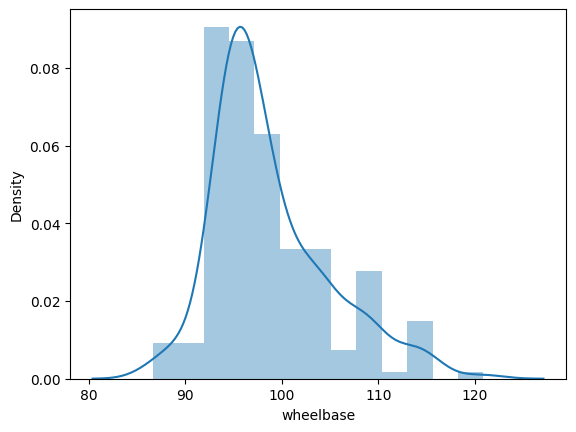

In [19]:
# wheelbase: distance between centre of front and rarewheels
sns.distplot(cars['wheelbase'])
plt.show()

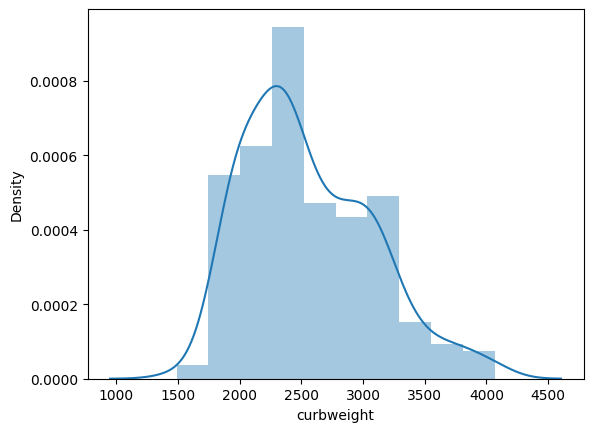

In [20]:
# curbweight: weight of car without occupants or baggage
sns.distplot(cars['curbweight'])
plt.show()

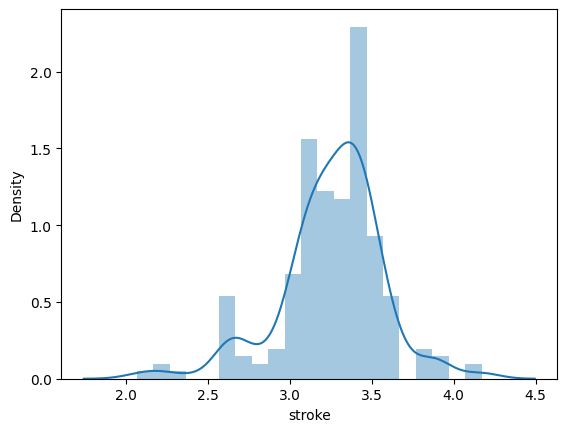

In [21]:
# stroke: volume of the engine (the distance traveled by the
# piston in each cycle)
sns.distplot(cars['stroke'])
plt.show()

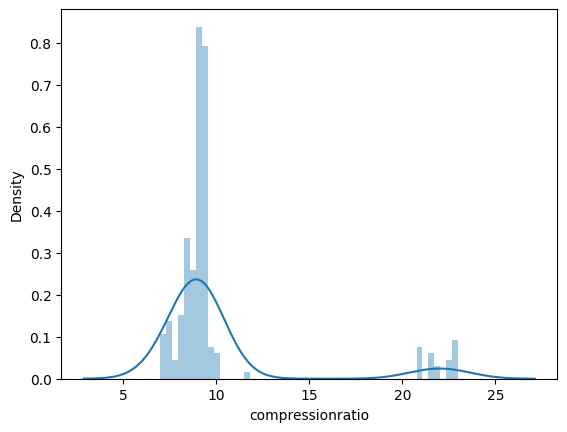

In [22]:
# compression ration: ratio of volume of compression chamber
# at largest capacity to least capacity
sns.distplot(cars['compressionratio'])
plt.show()

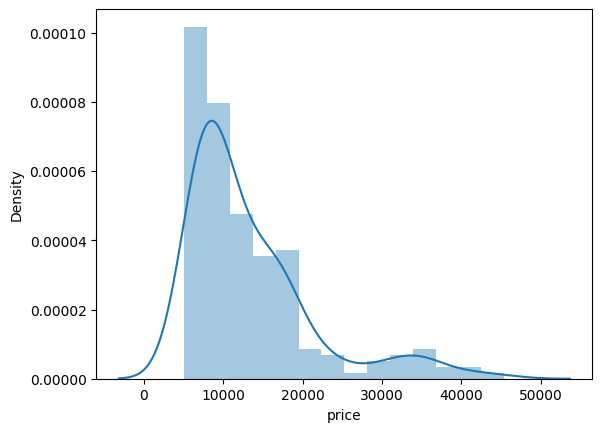

In [23]:
# target variable: price of car
sns.distplot(cars['price'])
plt.show()

#### Data Exploration

To perform linear regression, the (numeric) target variable should be linearly related to *at least one another numeric variable*. Let's see whether that's true in this case.


We'll first subset the list of all (independent) numeric variables, and then make a **pairwise plot**.

In [24]:
# all numeric (float and int) variables in the dataset
cars_numeric = cars.select_dtypes(include=['float64', 'int64'])
cars_numeric.head()

,car_ID,symboling,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,94.5,171.2,65.5,52.4,2823,152,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,99.8,176.6,66.2,54.3,2337,109,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,99.4,176.6,66.4,54.3,2824,136,3.19,3.40,8.0,115,5500,18,22,17450.0


Here, although the variable ```symboling``` is numeric (int), we'd rather treat it as categorical since it has only 6 discrete values. Also, we do not want 'car_ID'.

In [25]:
# dropping symboling and car_ID
cars_numeric = cars_numeric.drop(['symboling'], axis=1)
cars_numeric.head()

,car_ID,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,94.5,171.2,65.5,52.4,2823,152,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,99.8,176.6,66.2,54.3,2337,109,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,99.4,176.6,66.4,54.3,2824,136,3.19,3.40,8.0,115,5500,18,22,17450.0


Let's now make a pairwise scatter plot and observe linear relationships.

<Figure size 2000x1000 with 0 Axes>

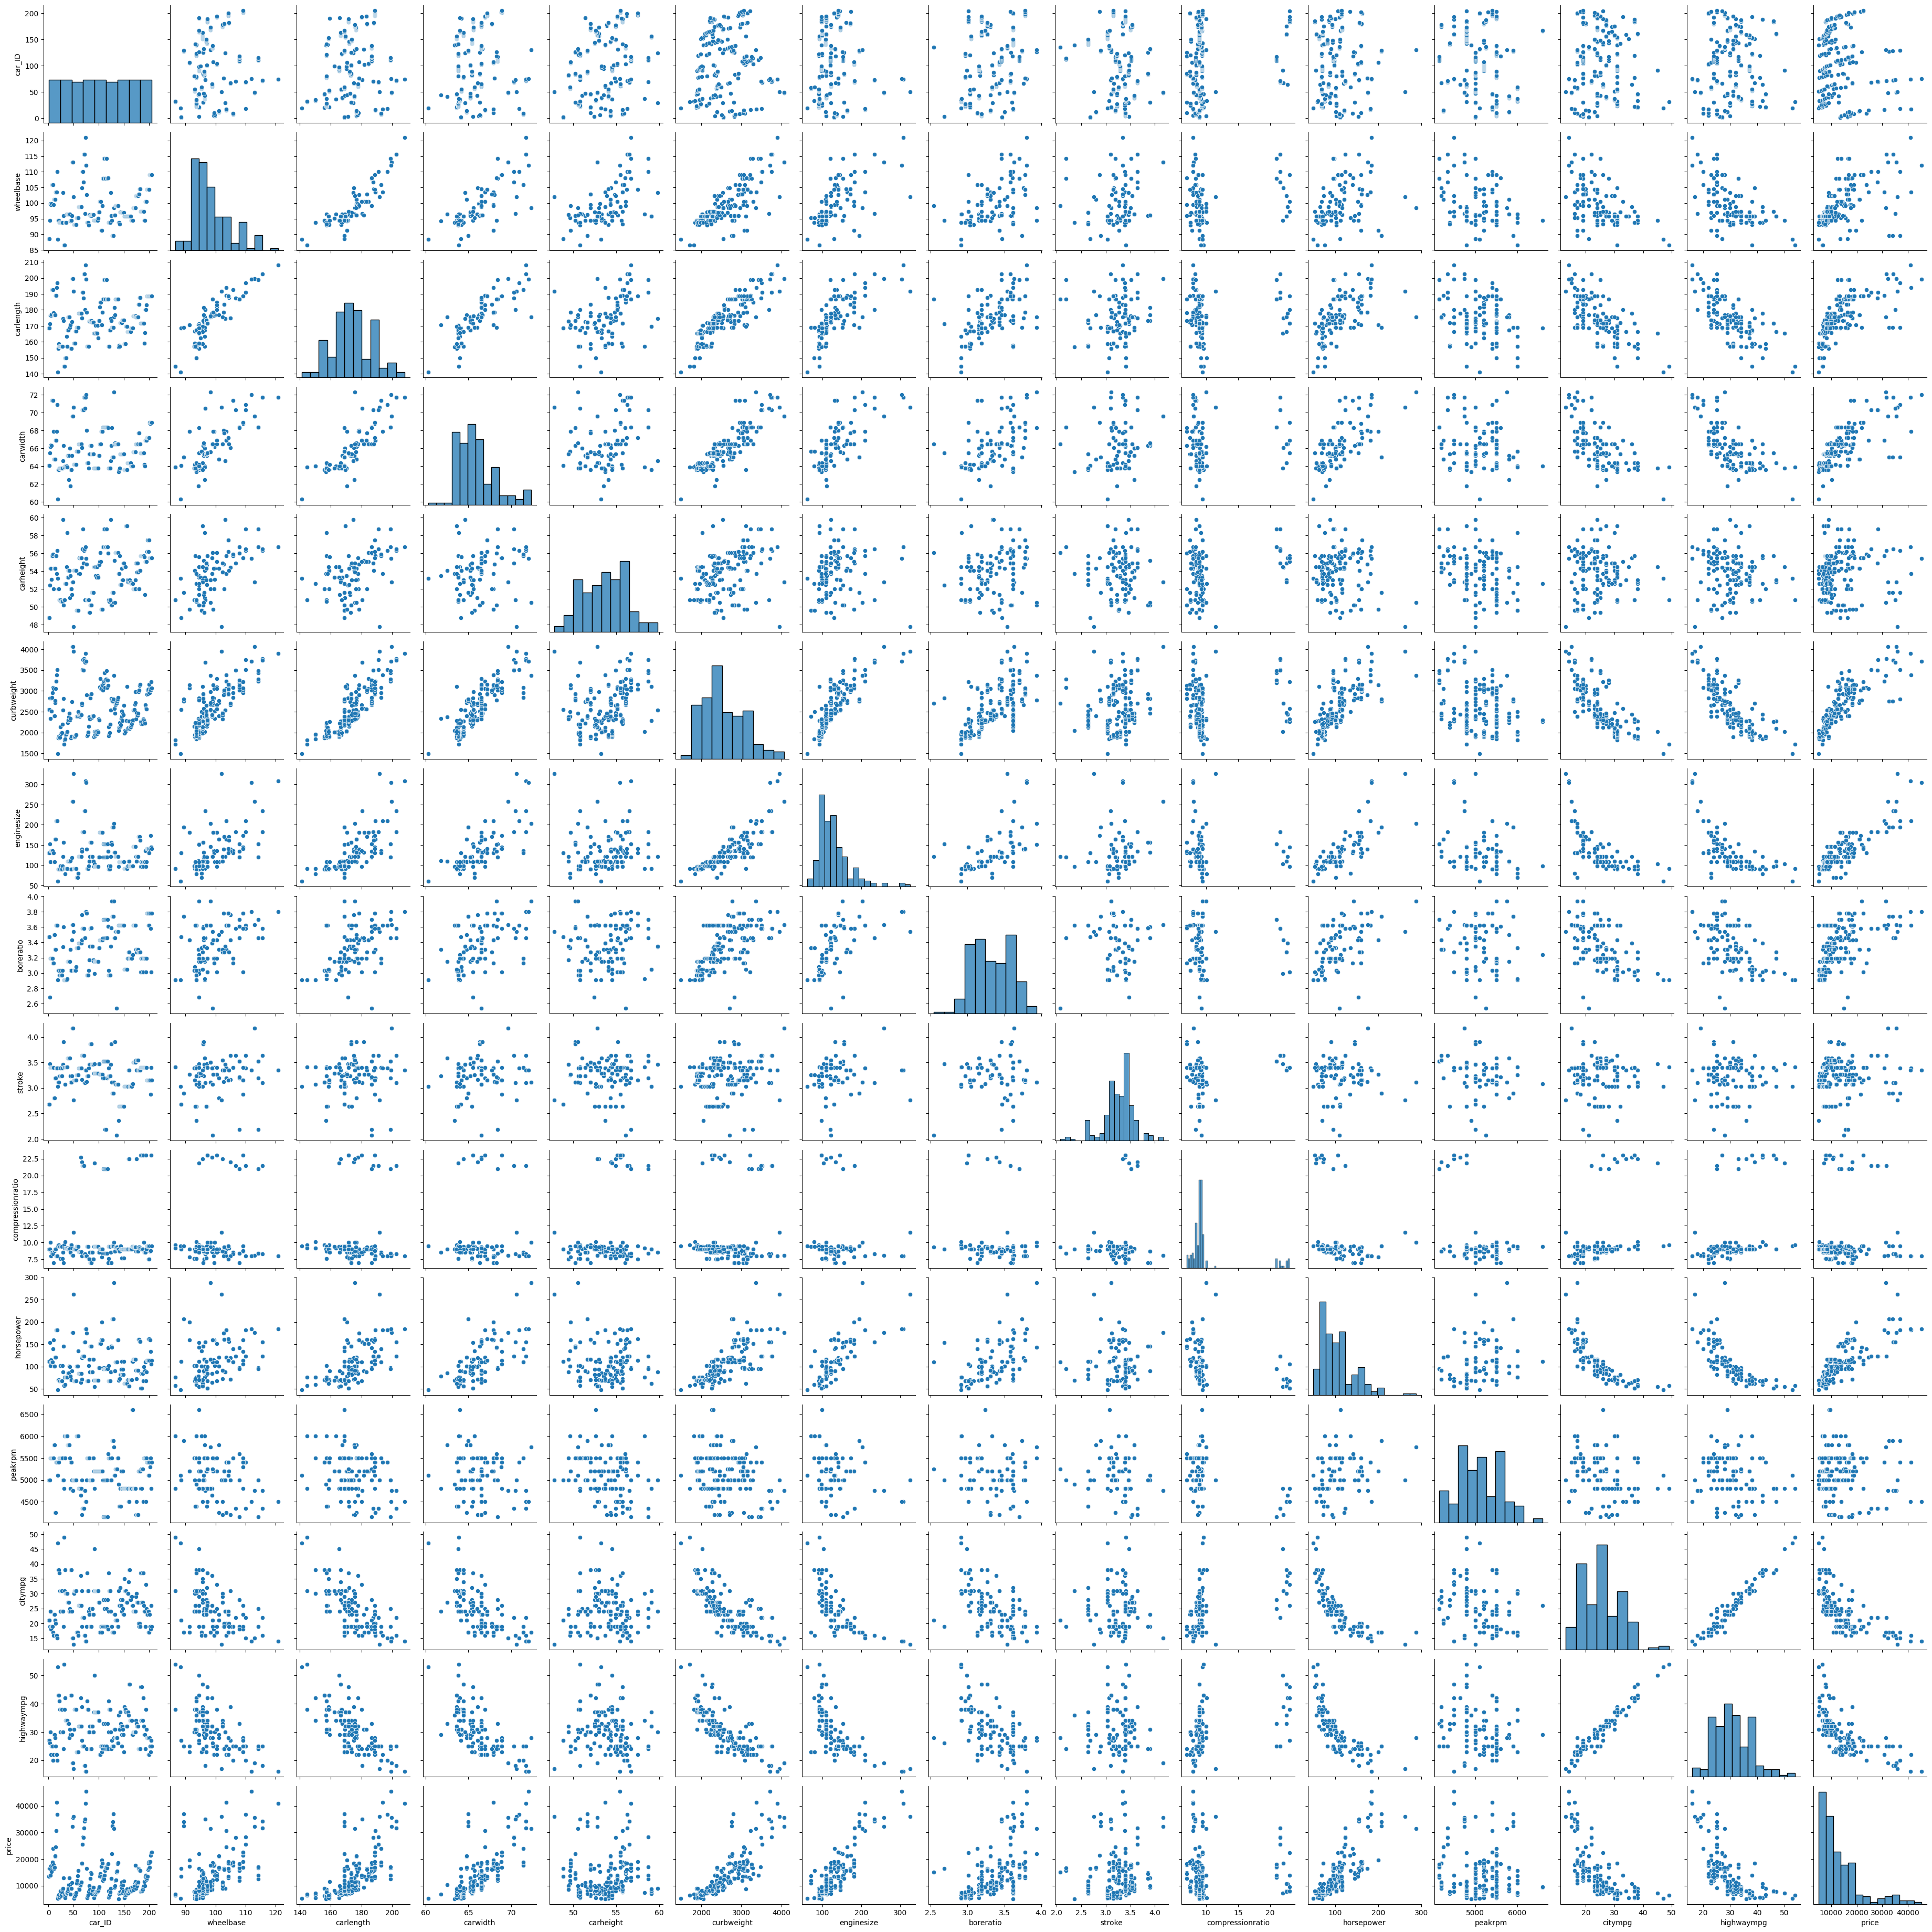

In [26]:
# paiwise scatter plot

plt.figure(figsize=(20, 10))
sns.pairplot(cars_numeric)
plt.show()

This is quite hard to read, and we can rather plot correlations between variables. Also, a heatmap is pretty useful to visualise multiple correlations in one plot.

In [27]:
# correlation matrix
cor = cars_numeric.corr()
cor

,car_ID,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
car_ID,1.000000,0.129729,0.170636,0.052387,0.255960,0.071962,-0.033930,0.260064,-0.160824,0.150276,-0.015006,-0.203789,0.015940,0.011255,-0.109093
wheelbase,0.129729,1.000000,0.874587,0.795144,0.589435,0.776386,0.569329,0.488750,0.160959,0.249786,0.353294,-0.360469,-0.470414,-0.544082,0.577816
carlength,0.170636,0.874587,1.000000,0.841118,0.491029,0.877728,0.683360,0.606454,0.129533,0.158414,0.552623,-0.287242,-0.670909,-0.704662,0.682920
carwidth,0.052387,0.795144,0.841118,1.000000,0.279210,0.867032,0.735433,0.559150,0.182942,0.181129,0.640732,-0.220012,-0.642704,-0.677218,0.759325
carheight,0.255960,0.589435,0.491029,0.279210,1.000000,0.295572,0.067149,0.171071,-0.055307,0.261214,-0.108802,-0.320411,-0.048640,-0.107358,0.119336
curbweight,0.071962,0.776386,0.877728,0.867032,0.295572,1.000000,0.850594,0.648480,0.168790,0.151362,0.750739,-0.266243,-0.757414,-0.797465,0.835305
enginesize,-0.033930,0.569329,0.683360,0.735433,0.067149,0.850594,1.000000,0.583774,0.203129,0.028971,0.809769,-0.244660,-0.653658,-0.677470,0.874145
boreratio,0.260064,0.488750,0.606454,0.559150,0.171071,0.648480,0.583774,1.000000,-0.055909,0.005197,0.573677,-0.254976,-0.584532,-0.587012,0.553173
stroke,-0.160824,0.160959,0.129533,0.182942,-0.055307,0.168790,0.203129,-0.055909,1.000000,0.186110,0.080940,-0.067964,-0.042145,-0.043931,0.079443
compressionratio,0.150276,0.249786,0.158414,0.181129,0.261214,0.151362,0.028971,0.005197,0.186110,1.000000,-0.204326,-0.435741,0.324701,0.265201,0.067984


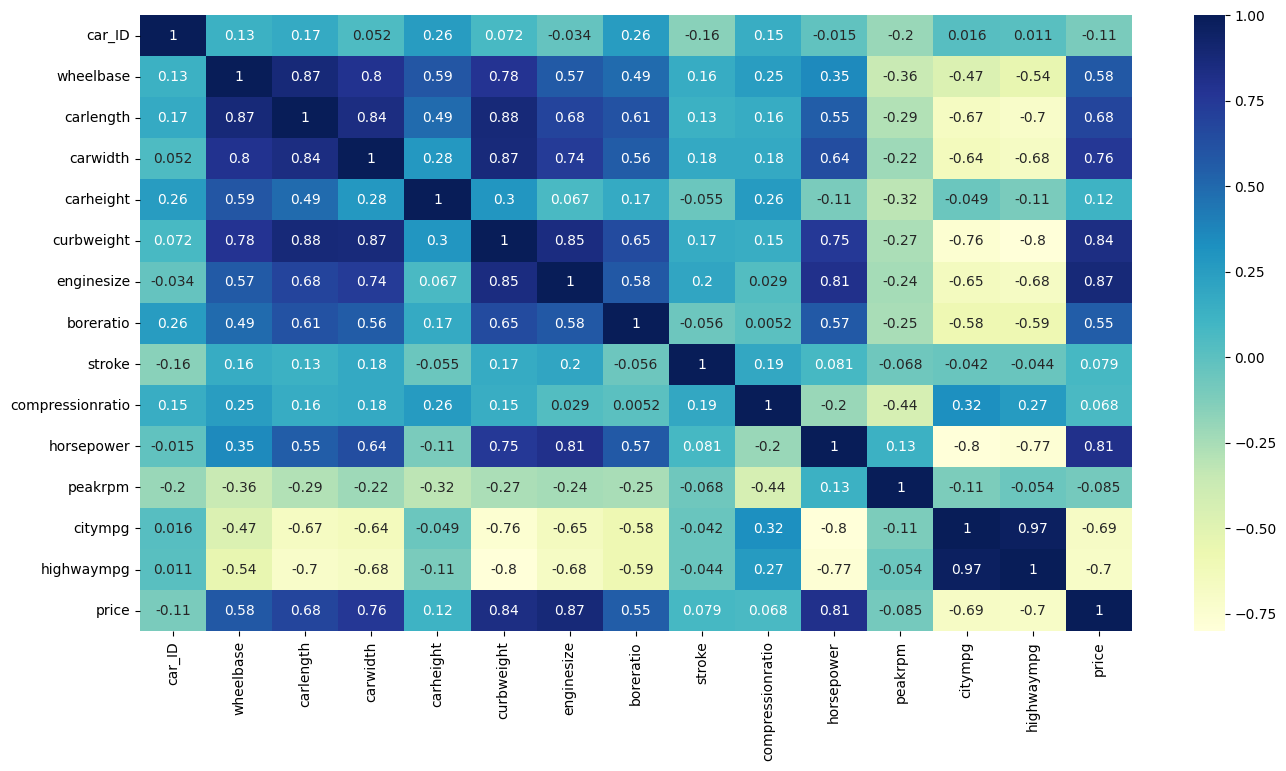

In [28]:
# plotting correlations on a heatmap

# figure size
plt.figure(figsize=(16,8))

# heatmap
sns.heatmap(cor, cmap="YlGnBu", annot=True)
plt.show()


The heatmap shows some useful insights:

Correlation of price with independent variables:
- Price is highly (positively) correlated with wheelbase, carlength, carwidth, curbweight, enginesize, horsepower (notice how all of these variables represent the size/weight/engine power of the car)

- Price is negatively correlated to ```citympg``` and ```highwaympg``` (-0.70 approximately). This suggest that cars having high mileage may fall in the 'economy' cars category, and are priced lower (think Maruti Alto/Swift type of cars, which are designed to be affordable by the middle class, who value mileage more than horsepower/size of car etc.)

Correlation among independent variables:
- Many independent variables are highly correlated (look at the top-left part of matrix): wheelbase, carlength, curbweight, enginesize etc. are all measures of 'size/weight', and are positively correlated


Thus, while building the model, we'll have to pay attention to multicollinearity (especially linear models, such as linear and logistic regression, suffer more from multicollinearity).

#### 2. Data Cleaning

Let's now conduct some data cleaning steps.

We've seen that there are no missing values in the dataset. We've also seen that variables are in the correct format, except ```symboling```, which should rather be a categorical variable (so that dummy variable are created for the categories).

Note that it *can* be used in the model as a numeric variable also.



In [29]:
# variable formats
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   CarName           205 non-null    object 
 3   fueltype          205 non-null    object 
 4   aspiration        205 non-null    object 
 5   doornumber        205 non-null    object 
 6   carbody           205 non-null    object 
 7   drivewheel        205 non-null    object 
 8   enginelocation    205 non-null    object 
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    object 
 15  cylindernumber    205 non-null    object 
 16  enginesize        205 non-null    int64  
 1

In [30]:
# converting symboling to categorical
cars['symboling'] = cars['symboling'].astype('object')
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    object 
 2   CarName           205 non-null    object 
 3   fueltype          205 non-null    object 
 4   aspiration        205 non-null    object 
 5   doornumber        205 non-null    object 
 6   carbody           205 non-null    object 
 7   drivewheel        205 non-null    object 
 8   enginelocation    205 non-null    object 
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    object 
 15  cylindernumber    205 non-null    object 
 16  enginesize        205 non-null    int64  
 1

Netx, we need to extract the company name from the column ```CarName```.

In [31]:
# CarName: first few entries
cars['CarName'][:30]

,CarName
0,alfa-romero giulia
1,alfa-romero stelvio
2,alfa-romero Quadrifoglio
3,audi 100 ls
4,audi 100ls
5,audi fox
6,audi 100ls
7,audi 5000
8,audi 4000
9,audi 5000s (diesel)


Notice that the carname is what occurs before a space, e.g. alfa-romero, audi, chevrolet, dodge, bmx etc.

Thus, we need to simply extract the string before a space. There are multiple ways to do that.




In [32]:
# Extracting carname

# Method 1: str.split() by space
carnames = cars['CarName'].apply(lambda x: x.split(" ")[0])
carnames[:30]

,CarName
0,alfa-romero
1,alfa-romero
2,alfa-romero
3,audi
4,audi
5,audi
6,audi
7,audi
8,audi
9,audi


In [33]:
# Method 2: Use regular expressions
import re

# regex: any alphanumeric sequence before a space, may contain a hyphen
p = re.compile(r'\w+-?\w+')
carnames = cars['CarName'].apply(lambda x: re.findall(p, x)[0])
print(carnames)

0      alfa-romero
1      alfa-romero
2      alfa-romero
3             audi
4             audi
          ...     
200          volvo
201          volvo
202          volvo
203          volvo
204          volvo
Name: CarName, Length: 205, dtype: object


Let's create a new column to store the compnay name and check whether it looks okay.

In [34]:
# New column car_company
cars['car_company'] = cars['CarName'].apply(lambda x: re.findall(p, x)[0])

In [35]:
# look at all values
cars['car_company'].astype('category').value_counts()

,count
car_company,
toyota,31
nissan,17
mazda,15
honda,13
mitsubishi,13
subaru,12
volvo,11
peugeot,11
dodge,9


Notice that **some car-company names are misspelled** - vw and vokswagen should be volkswagen, porcshce should be porsche, toyouta should be toyota, Nissan should be nissan, maxda should be mazda etc.

This is a data quality issue, let's solve it.

In [36]:
# replacing misspelled car_company names

# volkswagen
cars.loc[(cars['car_company'] == "vw") |
         (cars['car_company'] == "vokswagen")
         , 'car_company'] = 'volkswagen'

# porsche
cars.loc[cars['car_company'] == "porcshce", 'car_company'] = 'porsche'

# toyota
cars.loc[cars['car_company'] == "toyouta", 'car_company'] = 'toyota'

# nissan
cars.loc[cars['car_company'] == "Nissan", 'car_company'] = 'nissan'

# mazda
cars.loc[cars['car_company'] == "maxda", 'car_company'] = 'mazda'

In [37]:
cars['car_company'].astype('category').value_counts()

,count
car_company,
toyota,32
nissan,18
mazda,17
mitsubishi,13
honda,13
subaru,12
volkswagen,12
peugeot,11
volvo,11


The ```car_company``` variable looks okay now. Let's now drop the car name variable.

In [38]:
# drop carname variable
cars = cars.drop('CarName', axis=1)

In [39]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    object 
 2   fueltype          205 non-null    object 
 3   aspiration        205 non-null    object 
 4   doornumber        205 non-null    object 
 5   carbody           205 non-null    object 
 6   drivewheel        205 non-null    object 
 7   enginelocation    205 non-null    object 
 8   wheelbase         205 non-null    float64
 9   carlength         205 non-null    float64
 10  carwidth          205 non-null    float64
 11  carheight         205 non-null    float64
 12  curbweight        205 non-null    int64  
 13  enginetype        205 non-null    object 
 14  cylindernumber    205 non-null    object 
 15  enginesize        205 non-null    int64  
 16  fuelsystem        205 non-null    object 
 1

In [40]:
# outliers
cars.describe()

,car_ID,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
count,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000
mean,103.000000,98.756585,174.049268,65.907805,53.724878,2555.565854,126.907317,3.329756,3.255415,10.142537,104.117073,5125.121951,25.219512,30.751220,13276.710571
std,59.322565,6.021776,12.337289,2.145204,2.443522,520.680204,41.642693,0.270844,0.313597,3.972040,39.544167,476.985643,6.542142,6.886443,7988.852332
min,1.000000,86.600000,141.100000,60.300000,47.800000,1488.000000,61.000000,2.540000,2.070000,7.000000,48.000000,4150.000000,13.000000,16.000000,5118.000000
25%,52.000000,94.500000,166.300000,64.100000,52.000000,2145.000000,97.000000,3.150000,3.110000,8.600000,70.000000,4800.000000,19.000000,25.000000,7788.000000
50%,103.000000,97.000000,173.200000,65.500000,54.100000,2414.000000,120.000000,3.310000,3.290000,9.000000,95.000000,5200.000000,24.000000,30.000000,10295.000000
75%,154.000000,102.400000,183.100000,66.900000,55.500000,2935.000000,141.000000,3.580000,3.410000,9.400000,116.000000,5500.000000,30.000000,34.000000,16503.000000
max,205.000000,120.900000,208.100000,72.300000,59.800000,4066.000000,326.000000,3.940000,4.170000,23.000000,288.000000,6600.000000,49.000000,54.000000,45400.000000


In [41]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    object 
 2   fueltype          205 non-null    object 
 3   aspiration        205 non-null    object 
 4   doornumber        205 non-null    object 
 5   carbody           205 non-null    object 
 6   drivewheel        205 non-null    object 
 7   enginelocation    205 non-null    object 
 8   wheelbase         205 non-null    float64
 9   carlength         205 non-null    float64
 10  carwidth          205 non-null    float64
 11  carheight         205 non-null    float64
 12  curbweight        205 non-null    int64  
 13  enginetype        205 non-null    object 
 14  cylindernumber    205 non-null    object 
 15  enginesize        205 non-null    int64  
 16  fuelsystem        205 non-null    object 
 1

#### 3. Data Preparation



Let's now prepare the data and build the model.

In [42]:
# split into X and y
X = cars.loc[:, ['symboling', 'fueltype', 'aspiration', 'doornumber',
       'carbody', 'drivewheel', 'enginelocation', 'wheelbase', 'carlength',
       'carwidth', 'carheight', 'curbweight', 'enginetype', 'cylindernumber',
       'enginesize', 'fuelsystem', 'boreratio', 'stroke', 'compressionratio',
       'horsepower', 'peakrpm', 'citympg', 'highwaympg',
       'car_company']]

y = cars['price']


In [43]:
# creating dummy variables for categorical variables

# subset all categorical variables
cars_categorical = X.select_dtypes(include=['object'])
cars_categorical.head()


,symboling,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,enginetype,cylindernumber,fuelsystem,car_company
0,3,gas,std,two,convertible,rwd,front,dohc,four,mpfi,alfa-romero
1,3,gas,std,two,convertible,rwd,front,dohc,four,mpfi,alfa-romero
2,1,gas,std,two,hatchback,rwd,front,ohcv,six,mpfi,alfa-romero
3,2,gas,std,four,sedan,fwd,front,ohc,four,mpfi,audi
4,2,gas,std,four,sedan,4wd,front,ohc,five,mpfi,audi


In [44]:
# convert into dummies
cars_dummies = pd.get_dummies(cars_categorical, drop_first=True)
cars_dummies.head()

,symboling_-1,symboling_0,symboling_1,symboling_2,symboling_3,fueltype_gas,aspiration_turbo,doornumber_two,carbody_hardtop,carbody_hatchback,...,car_company_nissan,car_company_peugeot,car_company_plymouth,car_company_porsche,car_company_renault,car_company_saab,car_company_subaru,car_company_toyota,car_company_volkswagen,car_company_volvo
0,False,False,False,False,True,True,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,True,True,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,True,False,False,True,False,True,False,True,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,True,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,True,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [45]:
# drop categorical variables
X = X.drop(list(cars_categorical.columns), axis=1)

In [46]:
# concat dummy variables with X
X = pd.concat([X, cars_dummies], axis=1)

In [47]:
# scaling the features
from sklearn.preprocessing import scale

# storing column names in cols, since column names are (annoyingly) lost after
# scaling (the df is converted to a numpy array)
cols = X.columns
X = pd.DataFrame(scale(X))
X.columns = cols
X.columns

Index(['wheelbase', 'carlength', 'carwidth', 'carheight', 'curbweight',
       'enginesize', 'boreratio', 'stroke', 'compressionratio', 'horsepower',
       'peakrpm', 'citympg', 'highwaympg', 'symboling_-1', 'symboling_0',
       'symboling_1', 'symboling_2', 'symboling_3', 'fueltype_gas',
       'aspiration_turbo', 'doornumber_two', 'carbody_hardtop',
       'carbody_hatchback', 'carbody_sedan', 'carbody_wagon', 'drivewheel_fwd',
       'drivewheel_rwd', 'enginelocation_rear', 'enginetype_dohcv',
       'enginetype_l', 'enginetype_ohc', 'enginetype_ohcf', 'enginetype_ohcv',
       'enginetype_rotor', 'cylindernumber_five', 'cylindernumber_four',
       'cylindernumber_six', 'cylindernumber_three', 'cylindernumber_twelve',
       'cylindernumber_two', 'fuelsystem_2bbl', 'fuelsystem_4bbl',
       'fuelsystem_idi', 'fuelsystem_mfi', 'fuelsystem_mpfi',
       'fuelsystem_spdi', 'fuelsystem_spfi', 'car_company_audi',
       'car_company_bmw', 'car_company_buick', 'car_company_chevrolet',


In [48]:
# split into train and test
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.7,
                                                    test_size = 0.3, random_state=100)

#### 3. Model Building and Evaluation

#### Ridge and Lasso Regression

Let's now try predicting car prices, a dataset used in simple linear regression, to perform ridge and lasso regression.

#### Ridge Regression

In [49]:
ridgeReg = Ridge(alpha=10)

ridgeReg.fit(X_train,y_train)

Ridge(alpha=10)

In [50]:
#train and test scorefor ridge regression
train_score_ridge = ridgeReg.score(X_train, y_train)
test_score_ridge = ridgeReg.score(X_test, y_test)

print("The train score for ridge model is {}".format(train_score_ridge))
print("The test score for ridge model is {}".format(test_score_ridge))

The train score for ridge model is 0.9588720781564705
The test score for ridge model is 0.9224482262406617


## Cross validation

### Issue with the approach so far

We have a training set
- and we are building a model on it

Then, we choose the value of lambda (λ)
- say, we chose lambda as = 0.01.
- and build a model with it.

<br>

#### Question: What did we do after building the model?

We took the test set and computed the $R^2$ metric on it.
- Suppose we got the $R^2$ metric as $x$

<br>

#### Question: What did we do next?

We took another value of lambda $λ$, say 0.1
- and trained the model

Again, using the same test data, we computed the $R^2$ metric
- say, we got the value of $R^2$ when $λ$ = 0.1  as y.


**Assumption:** Assume that the value of $y > x$






<center>
<img src="https://drive.google.com/uc?id=1E70SR4SCQJFFKuliP1crHRCcG6guqtCw" width =600> </center>



#### Question: Which is the better hyperparam in this case?

Ans: 0.1

#### Question: Is there a problem with this approach ?

Ans: The problem is we are relying on the test data to find the best hyperparam.
- i.e. we are using test data for training which shouldn't be done.
- Test data should only be used to check the performance of model on unseen data.


**Using the test data for hyperparam tuning is not good step. Never do it**

### How can we resolve this issue ?

Instead of single test data, what if we had two different test data ?

We divide our data s.t.
- we have 60% of our data as train data
- 20% of data as test1
- rest 20% as test2.

Do note that, this data split percentage can change. It can be 70-15-15 as well depending on the number of datapoint we have.


<center>
<img src="https://drive.google.com/uc?id=1KxCdKEw7ns3nv0aglCoTB7VMzKkRVZab" width =600> </center>


We build the model using a value of $λ$
- Then we use the test1 data to check whether the $R^2$ is good or not.
- We then try with another value of lambda say $λ_1$ and get another value of $R^2$

Suppose we chose that $λ_1$ is good value using the value of test1 dataset
- We didn't use the value of test2 at all in this process.

As soon as we chose the value of λ using the test1,
- we'll check the performance of model on test2 data

This process will give us pretty good confidence on whether the lambda we chose using test1 data is performing good on unseen data (test2 data)




<center>
<img src="https://drive.google.com/uc?id=1YjKVhtB89v_5Q_lxTWwY6JTYj-qP_ghJ" width =600> </center>




This test1 data is calling **Cross validation data**


<center>
<img src="https://drive.google.com/uc?id=1vL0Y5c6XiJkUohIJj-OCCnOUSWk2-RVc" width =600> </center>


### How to find optimal lambda ($λ_{best}$)

#### Plotting error vs lambda (λ)

#### Question: When our lambda value is small, will be underfit or overfit ?

Ans: Overfit.

The loss function is as follows:


<img src="https://drive.google.com/uc?id=1xtgAh9yKfJmk-xvct8M0MF858USQwbAa">

When lambda value is 0
- it means regularization term is becomes zero
- hence, model will overfit.

When model overfit,
- it means training loss will be minimal

As we keep on increasing the value of lambda
- training loss will increase




<center>
<img src="https://drive.google.com/uc?id=1ff5yQFg93jB-wsUdLBMz1mE8Rlw707r-" width =600> </center>



#### Question: What will be CV loss when lambda value is small ?

Ans: Error will be high

As we have overfit the model,
- i.e model is performing good on training data
- but bad on test/cv data.

#### Question: If the value of lambda is very high, what will be the value of CV loss ?

Ans: CV loss will be high

If the value of lambda is very high
- model will underfit
- as we are paying more importance to regularization
- model bias will increase


As we increase the value of lambda
- CV loss will be high intially
- then it'll decrease upto a point
- and then as value of lambda increase, the error will increase as well.

<center>
<img src="https://drive.google.com/uc?id=127WP5LGTppTI1A0Bq1he9qUIJ0sT6PE-" width =600> </center>



Using the above plot, we'll choose the best lambda s.t.
- the cv error will be minimal


### Issues with cross validation

We initially split our data into train and test
- Out of train data, we again split our data into train and cross validation data, say (80-20 split)



<center>
<img src="https://drive.google.com/uc?id=1ElRtpRhNZilB180oZIAXMMEbbxuLKvjn" width =600> </center>



Now, it could be possible that this 20% of CV data is biased enough to give you different result ($R^2$)

Imagine if we did the split differently,
- starting 20% as CV
- rest as train data.

We may end up with different $R^2$ if we choose first 20% or last 20% depending on if the last 20% data is biased.

<center>
<img src="https://drive.google.com/uc?id=1hRla-Ww2rrxl05QdFnSAjrg9Ltndun5t" width =600> </center>

#### How do we resolve this issue ?

### K-Fold CV

Say, we have 100 records
- and we divided it into 5 equal parts i.e. 20 records per part.

First time,
- we'll take fist part i.e. 20% of data as test/cv data
- and remaining 4 part as train data

Based on this data, we get the $R^2$, say $R_1^2$

Next time, we take
- Second part as test/cv data
- Rest of the data as train data
- and calculate the performance on it, say $R_2^2$

Similarly, we'll get $R_3^2, R_4^2$ and $R_5^2$

Now, we'll take the average of $R_i^2$, and it can be better estimate of performance for us.
- We'll have much more confidence on our result.

<center>
<img src="https://drive.google.com/uc?id=1Lzdxy5XtJSuATuB_UYdj9e1ABthEz1RJ" width =600> </center>


Suppose the $R^2$ for first fold is high and low for last 2 folds.
Then, it can be possible that model is not reliable as
- as soon as we change our data, $R^2$ also changes (Red flag)

All the $R_i^2$ should be reasonable close / similar.

### Choosing the correct parameter
## Grid search


The performance of a model significantly depends on the value of hyperparameters. There is no way to know in advance the best values for hyperparameters so ideally, we need to try all possible values to know the optimal values. Doing this manually could take a considerable amount of time and resources and thus we use GridSearchCV to automate the tuning of hyperparameters.
It runs through all the different parameters that is fed into the parameter grid and produces the best combination of parameters, based on a scoring metric

GridSearchCV is the process of performing hyperparameter tuning in order to determine the optimal values for a given model.


- specify the range of hyperparameter values
- try every possible combination
- choose the optimal parameter

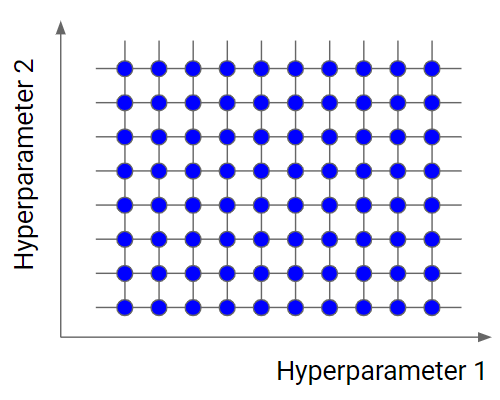

**Instructor Note : We'll talk about folds just after this**

In [51]:
# list of alphas to tune
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1,
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}


ridge = Ridge()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = ridge,
                        param_grid = params,
                        scoring= 'neg_mean_absolute_error',
                        cv = folds,
                        return_train_score=True,
                        verbose = 1)
model_cv.fit(X_train, y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [52]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results = cv_results[cv_results['param_alpha']<=200]
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.008350,0.003065,0.003663,0.001197,0.0001,{'alpha': 0.0001},-2854.116752,-1413.812300,-1531.761541,-3968.369904,...,-2466.863611,937.837752,26,-694.753230,-814.178930,-832.351826,-903.775793,-720.171139,-793.046184,76.452403
1,0.006000,0.000846,0.002958,0.000850,0.0010,{'alpha': 0.001},-2846.765330,-1412.112714,-1533.523778,-3944.973694,...,-2460.751844,929.782223,25,-695.179504,-813.808050,-831.764642,-903.295166,-719.845373,-792.778547,76.185169
2,0.006916,0.001861,0.003775,0.000756,0.0100,{'alpha': 0.01},-2784.176328,-1396.101814,-1548.469470,-3780.266249,...,-2415.039453,873.169878,24,-699.262955,-811.621551,-827.106090,-898.841647,-717.550342,-790.876517,73.714558
3,0.006104,0.001091,0.003816,0.000953,0.0500,{'alpha': 0.05},-2640.682659,-1355.068116,-1580.736324,-3300.686592,...,-2285.104051,719.477783,23,-713.345673,-812.877044,-817.962405,-886.516756,-711.346429,-788.409662,67.335524
4,0.006348,0.002401,0.004896,0.001034,0.1000,{'alpha': 0.1},-2563.275484,-1359.228650,-1589.294656,-2966.273419,...,-2198.282455,615.981941,22,-721.902772,-815.578758,-811.644501,-878.629933,-708.742470,-787.299687,63.532012


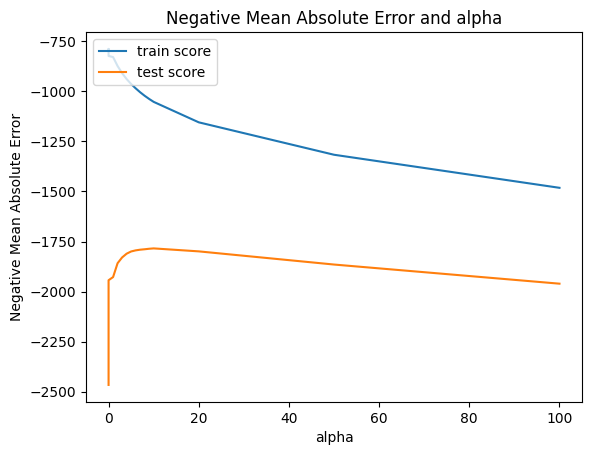

In [53]:
# plotting mean test and train scoes with alpha
cv_results['param_alpha'] = cv_results['param_alpha'].astype('int32')

# plotting
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')
plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper left')
plt.show()

In [54]:
alpha = 15
ridge = Ridge(alpha=alpha)

ridge.fit(X_train, y_train)
ridge.coef_

array([ 3.52557941e+02,  9.46530017e+01,  1.34511343e+03, -3.35849314e+02,
        1.16515775e+03,  1.33122540e+03, -1.18579444e+01, -2.84669666e+02,
        1.23313363e+01,  9.29481098e+02,  3.23313329e+02, -2.04711197e+01,
       -8.41293665e+01,  2.21783691e+02,  1.66376475e+02,  6.11555386e+01,
       -1.75468993e+01,  2.28698304e+02, -2.11820147e+02,  4.11053298e+02,
        1.01320701e+02,  2.63588369e+01, -5.29501748e+02, -2.71545584e+02,
       -2.23762142e+02, -2.44396310e+02,  2.61656901e+02,  9.20191503e+02,
       -1.93176012e+01, -2.18315631e+02,  3.13602886e+02,  2.38744211e+01,
        3.92105941e+00,  9.46640067e+01, -4.24237855e+02, -5.81409615e+02,
       -1.05817250e+02,  2.93070489e+02, -2.36048487e+02,  9.46640067e+01,
        5.15255069e+01, -1.79077288e+02,  2.11820147e+02, -2.28587306e-28,
       -3.95308641e+00, -1.36403005e+02, -2.28587306e-28,  3.35662090e+02,
        1.46679730e+03,  1.05750051e+03, -1.30931401e+02, -3.49739603e+02,
       -2.82007527e+02, -

#### Lasso

In [55]:
lasso = Lasso()

# cross validation
model_cv = GridSearchCV(estimator = lasso,
                        param_grid = params,
                        scoring= 'neg_mean_absolute_error',
                        cv = folds,
                        return_train_score=True,
                        verbose = 1)

model_cv.fit(X_train, y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [56]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.020441,0.003705,0.003188,0.000259,0.0001,{'alpha': 0.0001},-2324.752863,-1442.052401,-1582.911324,-3365.795489,...,-2209.514582,685.115001,15,-707.533143,-813.096166,-825.366072,-900.619438,-714.974164,-792.317797,72.696148
1,0.011876,0.001004,0.002247,0.000144,0.0010,{'alpha': 0.001},-2325.597811,-1441.914232,-1582.918610,-3365.543227,...,-2209.575240,685.082344,16,-707.541145,-813.094508,-825.357146,-900.608340,-714.974339,-792.315096,72.690031
2,0.011861,0.000738,0.002232,0.000054,0.0100,{'alpha': 0.01},-2334.050379,-1440.536627,-1582.991423,-3363.022314,...,-2210.185916,684.768785,17,-707.632117,-813.079516,-825.273418,-900.497476,-714.975747,-792.291655,72.627018
3,0.011230,0.000355,0.002069,0.000046,0.0500,{'alpha': 0.05},-2371.746047,-1434.479193,-1583.311429,-3351.844342,...,-2213.000651,683.667517,19,-708.062390,-813.098957,-825.058880,-900.011123,-715.024017,-792.251073,72.353255
4,0.011180,0.000172,0.002046,0.000133,0.1000,{'alpha': 0.1},-2419.028230,-1426.999122,-1583.704217,-3337.915603,...,-2216.697355,682.964265,20,-708.611287,-813.186719,-824.854499,-899.429607,-715.099045,-792.236231,72.023011


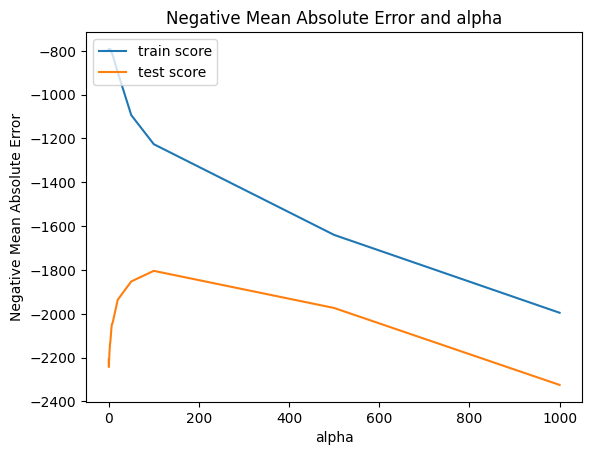

In [57]:
# plotting mean test and train scoes with alpha
cv_results['param_alpha'] = cv_results['param_alpha'].astype('float32')

# plotting
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')

plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper left')
plt.show()

In [58]:
alpha =100

lasso = Lasso(alpha=alpha)

lasso.fit(X_train, y_train)

Lasso(alpha=100)

In [59]:
lasso.coef_

array([   0.        ,   -0.        , 1747.1052243 ,  -82.23183774,
       1780.64173078,  788.28807799,   -0.        ,   -0.        ,
          0.        , 1017.48820119,   84.89633333,    0.        ,
         -0.        ,    0.        ,   -0.        ,   -0.        ,
          0.        ,  246.519852  ,  -73.38572878,  120.56790634,
          0.        ,    0.        , -187.60748943,    0.        ,
        -96.25412649, -134.39227325,  294.27227486, 1218.02281069,
          0.        ,   -0.        ,    0.        ,   -0.        ,
         -0.        ,    0.        ,   -0.        , -202.47407284,
         -0.        ,  197.70712322,   -0.        ,    0.        ,
         -0.        ,   -0.        ,   58.81424436,   -0.        ,
          0.        ,   -0.        ,   -0.        ,  186.35685239,
       1805.30123983, 1210.72936345,    0.        ,   -0.        ,
         -0.        ,   78.54297249,  796.29612837,    0.        ,
         -0.        , -397.80411254,  -58.198149  , -377.78256

You can see that Lasso regression has made the coefficients for many irrelevant columns as 0 (zero).

### Code walkthrough

#### Predict housing price

#### Importing libraries

In [101]:
# import all libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import scale
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

import warnings # supress warnings
warnings.filterwarnings('ignore')

#### Importing data

In [102]:
!gdown 1BnZvmMInJYAAQWhCl33Ib9hdxFtfuH5O

Downloading...
From: https://drive.google.com/uc?id=1BnZvmMInJYAAQWhCl33Ib9hdxFtfuH5O
To: /content/Housing.csv
100% 30.0k/30.0k [00:00<00:00, 60.2MB/s]


In [103]:
# import Housing.csv
housing = pd.read_csv('Housing.csv')
housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [104]:
# number of observations
len(housing.index)

545

For the first experiment, we'll do regression with only one feature. Let's filter the data so it only contains `area` and `price`.

In [105]:
# filter only area and price
df = housing.loc[:, ['area', 'price']]
df.head()

,area,price
0,7420,13300000
1,8960,12250000
2,9960,12250000
3,7500,12215000
4,7420,11410000


#### Scaling the data

In [106]:
# recaling the variables (both)
df_columns = df.columns
scaler = MinMaxScaler()
df = scaler.fit_transform(df)

# rename columns (since now its an np array)
df = pd.DataFrame(df)
df.columns = df_columns

df.head()

,area,price
0,0.396564,1.000000
1,0.502405,0.909091
2,0.571134,0.909091
3,0.402062,0.906061
4,0.396564,0.836364


#### Visualizing

<Axes: xlabel='area', ylabel='price'>

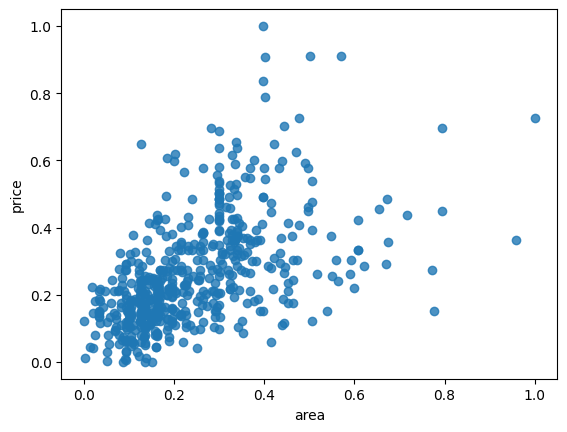

In [107]:
# visualise area-price relationship
sns.regplot(x="area", y="price", data=df, fit_reg=False)

#### Splitting data

In [108]:
# split into train and test
df_train, df_test = train_test_split(df,
                                     train_size = 0.7,
                                     test_size = 0.3,
                                     random_state = 10)
print(len(df_train))
print(len(df_test))

381
164


In [109]:
# split into X and y for both train and test sets
# reshaping is required since sklearn requires the data to be in shape
# (n, 1), not as a series of shape (n, )
X_train = df_train['area']
X_train = X_train.values.reshape(-1, 1)
y_train = df_train['price']

X_test = df_test['area']
X_test = X_test.values.reshape(-1, 1)
y_test = df_test['price']

You already know simple linear regression:

$y = \beta_0 + \beta_1 x_1$

In polynomial regression of degree $n$, we fit a curve of the form:

$y = \beta_0 + \beta_1 x_1 + \beta_2x_1^2 + \beta_3x_1^3 ... + \beta_nx_1^n$

In the experiment below, we have fitted polynomials of various degrees on the housing data and compared their performance on train and test sets.

In sklearn, polynomial features can be generated using the `PolynomialFeatures` class. Also, to perform `LinearRegression` and `PolynomialFeatures` in tandem, we will use the module `sklearn_pipeline` - it basically creates the features and feeds the output to the model (in that sequence).

In [110]:
len(X_train)

381

In [111]:
y_train

,price
175,0.303030
25,0.587879
253,0.239394
257,0.236364
431,0.133333
...,...
369,0.166667
320,0.200000
527,0.045455
125,0.363030


Let's now predict the y labels (for both train and test sets) and store the predictions in a table. Each row of the table is one data point, each column is a value of $n$ (degree).

<center>
<table style="width:100%">
  <tr>
    <th>   </th>
    <th>degree-1</th>
    <th>degree-2</th>
    <th>degree-3</th>
    <th>...</th>
    <th>degree-n</th>
  </tr>
  <tr>
    <th>x1</th>
  </tr>
  <tr>
    <th>x2</th>
  </tr>
   <tr>
    <th>x3</th>
    </tr>
    <tr>
    <th>...</th>
    </tr>
    <tr>
    <th>xn</th>
    </tr>
</table>
</center>

#### Fitting polynomial regression with multiple degrees

In [112]:
# fit multiple polynomial features
degrees = [1, 2, 3, 6, 10, 20]

# initialise y_train_pred and y_test_pred matrices to store the train and test predictions
# each row is a data point, each column a prediction using a polynomial of some degree
y_train_pred = np.zeros((len(X_train), len(degrees)))
y_test_pred = np.zeros((len(X_test), len(degrees)))

for i, degree in enumerate(degrees):

    # make pipeline: create features, then feed them to linear_reg model
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(X_train, y_train)

    # predict on test and train data
    # store the predictions of each degree in the corresponding column
    y_train_pred[:, i] = model.predict(X_train)
    y_test_pred[:, i] = model.predict(X_test)


In [113]:
y_test_pred

array([[ 1.79351332e-01,  1.56424129e-01,  1.56511935e-01,
         1.49066164e-01,  1.42530607e-01,  1.40014496e-01],
       [ 2.18810499e-01,  2.21985918e-01,  2.21759197e-01,
         2.03260056e-01,  2.08066026e-01,  2.13799217e-01],
       [ 2.39205125e-01,  2.52506989e-01,  2.52215681e-01,
         2.38963896e-01,  2.40910090e-01,  2.44096871e-01],
       [ 2.79107653e-01,  3.05590066e-01,  3.05325453e-01,
         3.12457483e-01,  3.01563313e-01,  2.97984011e-01],
       [ 3.05709338e-01,  3.36102266e-01,  3.35942345e-01,
         3.56121543e-01,  3.51544041e-01,  3.51563536e-01],
       [ 3.37187999e-01,  3.67168760e-01,  3.67192635e-01,
         3.94534463e-01,  4.08983951e-01,  4.07598608e-01],
       [ 3.81080780e-01,  4.01367743e-01,  4.01700010e-01,
         4.16608188e-01,  4.28062170e-01,  4.41261692e-01],
       [ 1.99302596e-01,  1.90646182e-01,  1.90541127e-01,
         1.73418123e-01,  1.72865826e-01,  1.67990028e-01],
       [ 1.63833683e-01,  1.28289838e-01,  1.285

#### Comparing R-squared values

In [114]:
# compare r2 for train and test sets (for all polynomial fits)
print("R-squared values: \n")

for i, degree in enumerate(degrees):
    train_r2 = round(sklearn.metrics.r2_score(y_train, y_train_pred[:, i]), 2)
    test_r2 = round(sklearn.metrics.r2_score(y_test, y_test_pred[:, i]), 2)
    print("Polynomial degree {0}: train score={1}, test score={2}".format(degree,
                                                                         train_r2,
                                                                         test_r2))

R-squared values: 

Polynomial degree 1: train score=0.29, test score=0.25
Polynomial degree 2: train score=0.34, test score=0.22
Polynomial degree 3: train score=0.34, test score=0.22
Polynomial degree 6: train score=0.36, test score=0.11
Polynomial degree 10: train score=0.37, test score=-108.76
Polynomial degree 20: train score=0.38, test score=-5612574004.27


#### 1. Building a Model Without Cross-Validation

Let's now build a multiple regression model. First, let's build a vanilla MLR model without any cross-validation etc.

In [115]:
# data preparation

# list of all the "yes-no" binary categorical variables
# we'll map yes to 1 and no to 0
binary_vars_list =  ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']

# defining the map function
def binary_map(x):
    return x.map({'yes': 1, "no": 0})

# applying the function to the housing variables list
housing[binary_vars_list] = housing[binary_vars_list].apply(binary_map)
housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,furnished
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,furnished
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,semi-furnished
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,furnished
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,furnished


In [116]:
# 'dummy' variables
# get dummy variables for 'furnishingstatus'
# also, drop the first column of the resulting df (since n-1 dummy vars suffice)
status = pd.get_dummies(housing['furnishingstatus'], drop_first = True)
status.head()

,semi-furnished,unfurnished
0,False,False
1,False,False
2,True,False
3,False,False
4,False,False


In [117]:
# concat the dummy variable df with the main df
housing = pd.concat([housing, status], axis = 1)
housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus,semi-furnished,unfurnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,furnished,False,False
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,furnished,False,False
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,semi-furnished,True,False
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,furnished,False,False
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,furnished,False,False


In [118]:
# 'furnishingstatus' since we alreday have the dummy vars
housing.drop(['furnishingstatus'], axis = 1, inplace = True)
housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,False,False
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,False,False
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,True,False
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,False,False
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,False,False


#### Splitting Into Train and Test

In [119]:
# train-test 70-30 split
df_train, df_test = train_test_split(housing,
                                     train_size = 0.7,
                                     test_size = 0.3,
                                     random_state = 100)

# rescale the features
scaler = MinMaxScaler()

# apply scaler() to all the numeric columns
numeric_vars = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking','price']
df_train[numeric_vars] = scaler.fit_transform(df_train[numeric_vars])
df_train.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished
359,0.169697,0.155227,0.4,0.0,0.000000,1,0,0,0,0,0.333333,0,False,True
19,0.615152,0.403379,0.4,0.5,0.333333,1,0,0,0,1,0.333333,1,True,False
159,0.321212,0.115628,0.4,0.5,0.000000,1,1,1,0,1,0.000000,0,False,False
35,0.548133,0.454417,0.4,0.5,1.000000,1,0,0,0,1,0.666667,0,False,False
28,0.575758,0.538015,0.8,0.5,0.333333,1,0,1,1,0,0.666667,0,False,True


#### Scaling data

In [120]:
# apply rescaling to the test set also
df_test[numeric_vars] = scaler.fit_transform(df_test[numeric_vars])
df_test.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished
265,0.247651,0.084536,0.333333,0.000000,0.333333,1,0,0,0,0,0.000000,1,True,False
54,0.530201,0.298969,0.333333,0.333333,0.333333,1,1,0,0,1,0.333333,0,True,False
171,0.328859,0.592371,0.333333,0.000000,0.000000,1,0,0,0,0,0.333333,1,True,False
244,0.261745,0.252234,0.333333,0.000000,0.333333,1,1,1,0,0,0.000000,1,True,False
268,0.245638,0.226804,0.666667,0.000000,0.333333,1,0,0,0,1,0.000000,0,True,False


In [121]:
# divide into X_train, y_train, X_test, y_test
y_train = df_train.pop('price')
X_train = df_train

y_test = df_test.pop('price')
X_test = df_test

Note that we haven't rescaled the test set yet, which we'll need to do later while making predictions.

#### Using RFE

Now, we have 13 predictor features. To build the model using RFE, we need to tell RFE how many features we want in the final model. It then runs a feature elimination algorithm.

Note that the number of features to be used in the model is a **hyperparameter**.

In [122]:
# num of max features
len(X_train.columns)

13

In [123]:
# first model with an arbitrary choice of n_features
# running RFE with number of features=10

lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, n_features_to_select=10)
rfe = rfe.fit(X_train, y_train)

In [124]:
# tuples of (feature name, whether selected, ranking)
# note that the 'rank' is > 1 for non-selected features
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('area', np.True_, np.int64(1)),
 ('bedrooms', np.True_, np.int64(1)),
 ('bathrooms', np.True_, np.int64(1)),
 ('stories', np.True_, np.int64(1)),
 ('mainroad', np.True_, np.int64(1)),
 ('guestroom', np.True_, np.int64(1)),
 ('basement', np.False_, np.int64(3)),
 ('hotwaterheating', np.True_, np.int64(1)),
 ('airconditioning', np.True_, np.int64(1)),
 ('parking', np.True_, np.int64(1)),
 ('prefarea', np.True_, np.int64(1)),
 ('semi-furnished', np.False_, np.int64(4)),
 ('unfurnished', np.False_, np.int64(2))]

In [125]:
# predict prices of X_test
y_pred = rfe.predict(X_test)

# evaluate the model on test set
r2 = sklearn.metrics.r2_score(y_test, y_pred)
print(r2)

0.5812051458999574


In [126]:
# try with another value of RFE
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, n_features_to_select=6)
rfe = rfe.fit(X_train, y_train)

# predict prices of X_test
y_pred = rfe.predict(X_test)
r2 = sklearn.metrics.r2_score(y_test, y_pred)
print(r2)

0.5350445027578821


#### 2. Problems in the Current Approach

In train-test split, we have three options:
1. **Simply split into train and test**: But that way tuning a hyperparameter makes the model 'see' the test data (i.e. knowledge of test data leaks into the model)
2. **Split into train, validation, test sets**: Then the validation data would eat into the training set
3. **Cross-validation**: Split into train and test, and train multiple models by sampling the train set. Finally, just test once on the test set.


#### 3. Cross-Validation: A Quick Recap

The following figure illustrates k-fold cross-validation with k=4. There are some other schemes to divide the training set, we'll look at them briefly later.

<center>
<img src="https://drive.google.com/uc?id=1TDXqJ1Jkrmrtd5L4JxaRaNzfj28tz0oI" width =600> </center>



#### 4. Cross-Validation in sklearn

Let's now experiment with k-fold CV.

#### 4.1 K-Fold CV

In [127]:
# k-fold CV (using all the 13 variables)
lm = LinearRegression()
scores = cross_val_score(lm, X_train, y_train, scoring='r2', cv=5)
scores

array([0.6829775 , 0.69324306, 0.6762109 , 0.61782891, 0.59266171])

In [128]:
# the other way of doing the same thing (more explicit)

# create a KFold object with 5 splits
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)
scores = cross_val_score(lm, X_train, y_train, scoring='r2', cv=folds)
scores

array([0.59930574, 0.71307628, 0.61325733, 0.62739077, 0.6212937 ])

In [129]:
# can tune other metrics, such as MSE
scores = cross_val_score(lm, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
scores

array([-0.00806336, -0.00658776, -0.0064797 , -0.0070743 , -0.01523682])

#### 4.2 Hyperparameter Tuning Using Grid Search Cross-Validation

A common use of cross-validation is for tuning hyperparameters of a model. The most common technique is what is called **grid search** cross-validation.


<center>
<img src="https://drive.google.com/uc?id=1bDFHvjYcjoOYGQmGn19PWSGTWFy1SqFC" width =600> </center>



In [130]:
# number of features in X_train
len(X_train.columns)

13

In [131]:
# step-1: create a cross-validation scheme
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

# step-2: specify range of hyperparameters to tune
hyper_params = [{'n_features_to_select': list(range(1, 14))}]


# step-3: perform grid search
# 3.1 specify model
lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(lm)

# 3.2 call GridSearchCV()
model_cv = GridSearchCV(estimator = rfe,
                        param_grid = hyper_params,
                        scoring= 'r2',
                        cv = folds,
                        verbose = 1,
                        return_train_score=True)

# fit the model
model_cv.fit(X_train, y_train)


Fitting 5 folds for each of 13 candidates, totalling 65 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             estimator=RFE(estimator=LinearRegression()),
             param_grid=[{'n_features_to_select': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13]}],
             return_train_score=True, scoring='r2', verbose=1)

In [132]:
# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_features_to_select,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.018144,0.004580,0.003420,0.000879,1,{'n_features_to_select': 1},0.172606,0.351721,0.206887,0.165910,...,0.243658,0.077627,13,0.302971,0.265961,0.280611,0.300768,0.269025,0.283867,0.015506
1,0.014447,0.000483,0.002891,0.000159,2,{'n_features_to_select': 2},0.335665,0.428751,0.439969,0.505321,...,0.438360,0.058374,12,0.505799,0.489802,0.462091,0.474178,0.471907,0.480755,0.015355
2,0.013238,0.000491,0.002848,0.000251,3,{'n_features_to_select': 3},0.421848,0.539257,0.491515,0.604426,...,0.516805,0.059902,11,0.568074,0.544917,0.542889,0.534685,0.542412,0.546596,0.011289
3,0.012859,0.002187,0.002636,0.000057,4,{'n_features_to_select': 4},0.449487,0.567101,0.494461,0.600237,...,0.526272,0.053074,10,0.587523,0.564018,0.549490,0.541496,0.549291,0.558364,0.016296
4,0.011051,0.000336,0.002740,0.000195,5,{'n_features_to_select': 5},0.494779,0.610200,0.492807,0.590812,...,0.541889,0.049257,8,0.620038,0.597033,0.584663,0.549413,0.589397,0.588109,0.022847
5,0.010195,0.000172,0.002755,0.000110,6,{'n_features_to_select': 6},0.512477,0.628849,0.488411,0.527379,...,0.541063,0.048029,9,0.626959,0.603122,0.596348,0.606852,0.601063,0.606869,0.010602
6,0.009036,0.000075,0.002619,0.000026,7,{'n_features_to_select': 7},0.568887,0.664093,0.552385,0.534634,...,0.577636,0.045006,7,0.658577,0.638501,0.630137,0.646285,0.638313,0.642363,0.009582
7,0.008122,0.000068,0.002629,0.000155,8,{'n_features_to_select': 8},0.570639,0.665608,0.592323,0.550001,...,0.591795,0.039428,6,0.674146,0.640825,0.654028,0.658665,0.657277,0.656988,0.010651
8,0.007249,0.000187,0.002607,0.000067,9,{'n_features_to_select': 9},0.578843,0.694189,0.606220,0.590777,...,0.615352,0.040767,4,0.676043,0.652605,0.659579,0.668996,0.664321,0.664309,0.007988
9,0.007166,0.000724,0.003059,0.000360,10,{'n_features_to_select': 10},0.574376,0.693197,0.601972,0.594335,...,0.608547,0.043498,5,0.686032,0.661729,0.674558,0.678443,0.677153,0.675583,0.007910


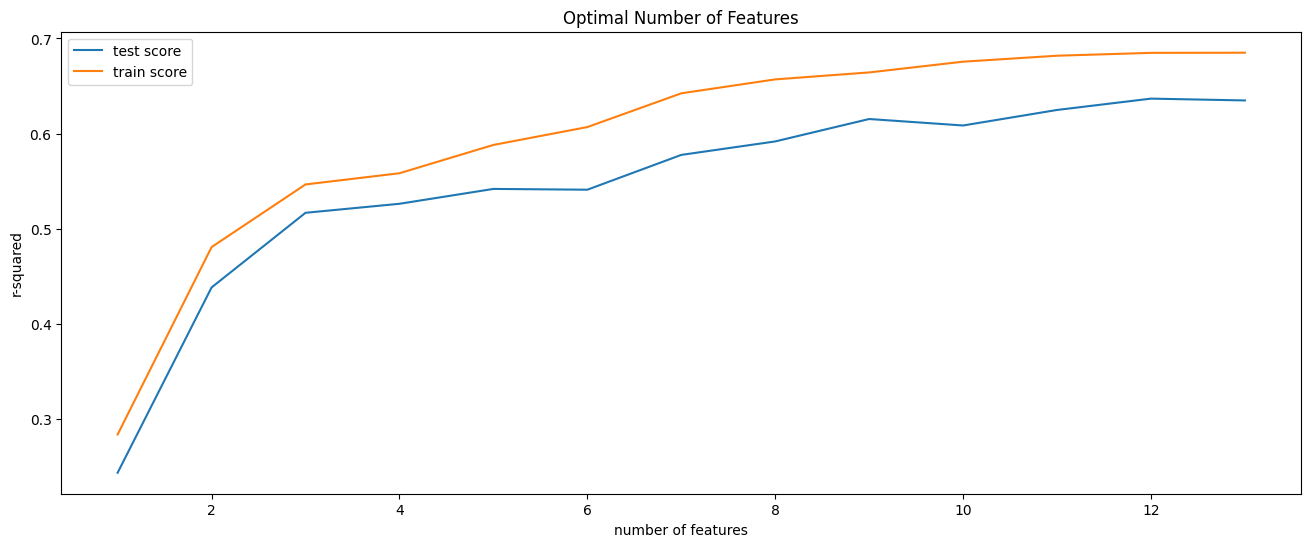

In [133]:
# plotting cv results
plt.figure(figsize=(16,6))

plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'], loc='upper left')

Now we can choose the optimal value of number of features and build a final model.

In [134]:
# final model
n_features_optimal = 10

lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, n_features_to_select=n_features_optimal)
rfe = rfe.fit(X_train, y_train)

# predict prices of X_test
y_pred = lm.predict(X_test)
r2 = sklearn.metrics.r2_score(y_test, y_pred)
print(r2)

0.5995575338728529


Notice that the test score is very close to the 'mean test score' on the k-folds (about 60%). In general, the mean score estimated by CV will usually be a good estimate of the test score.

#### 4.3 Types of Cross-Validation Schemes


1. **K-Fold** cross-validation: Most common
2. **Leave One Out (LOO)**: Takes each data point as the 'test sample' once, and trains the model on the rest n-1 data points. Thus, it trains n total models.
    - Advantage: Utilises the data well since each model is trained on n-1 samples
    - Disadvantage: Computationally expensive
3. **Leave P-Out (LPO)**: Creat all possible splits after leaving p samples out. For n data points, there are (nCp) possibile train-test splits.
4. (**For classification problems**) **Stratified K-Fold**: Ensures that the relative class proportion is approximately preserved in each train and validation fold. Important when ther eis huge class imbalance (e.g. 98% good customers, 2% bad).

#### Additional Reading ####
The sklearn documentation enlists all CV schemes <a href="http://scikit-learn.org/stable/modules/cross_validation.html">here.</a>


### Another Example: Car Price Prediction

#### reading the dataset

In [94]:
!gdown 1Zim4ODFec7nQqx5W_l8XzwzC_IB-3rmq

Downloading...
From: https://drive.google.com/uc?id=1Zim4ODFec7nQqx5W_l8XzwzC_IB-3rmq
To: /content/CarPrice_Assignment.csv
100% 26.7k/26.7k [00:00<00:00, 47.1MB/s]


In [95]:
cars = pd.read_csv("CarPrice_Assignment.csv")

#### Data preparation

In [96]:
# All data preparation steps in this cell

# converting symboling to categorical
cars['symboling'] = cars['symboling'].astype('object')


# create new column: car_company
p = re.compile(r'\w+-?\w+')
cars['car_company'] = cars['CarName'].apply(lambda x: re.findall(p, x)[0])


# replacing misspelled car_company names
# volkswagen
cars.loc[(cars['car_company'] == "vw") |
         (cars['car_company'] == "vokswagen")
         , 'car_company'] = 'volkswagen'
# porsche
cars.loc[cars['car_company'] == "porcshce", 'car_company'] = 'porsche'
# toyota
cars.loc[cars['car_company'] == "toyouta", 'car_company'] = 'toyota'
# nissan
cars.loc[cars['car_company'] == "Nissan", 'car_company'] = 'nissan'
# mazda
cars.loc[cars['car_company'] == "maxda", 'car_company'] = 'mazda'


# drop carname variable
cars = cars.drop('CarName', axis=1)


# split into X and y
X = cars.loc[:, ['symboling', 'fueltype', 'aspiration', 'doornumber',
       'carbody', 'drivewheel', 'enginelocation', 'wheelbase', 'carlength',
       'carwidth', 'carheight', 'curbweight', 'enginetype', 'cylindernumber',
       'enginesize', 'fuelsystem', 'boreratio', 'stroke', 'compressionratio',
       'horsepower', 'peakrpm', 'citympg', 'highwaympg',
       'car_company']]
y = cars['price']


# creating dummy variables for categorical variables
cars_categorical = X.select_dtypes(include=['object'])
cars_categorical.head()


# convert into dummies
cars_dummies = pd.get_dummies(cars_categorical, drop_first=True)
cars_dummies.head()


# drop categorical variables
X = X.drop(list(cars_categorical.columns), axis=1)


# concat dummy variables with X
X = pd.concat([X, cars_dummies], axis=1)


# rescale the features
cols = X.columns
X = pd.DataFrame(scale(X))
X.columns = cols


# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.7,
                                                    test_size = 0.3, random_state=40)

In [97]:
# number of features
len(X_train.columns)

68

In [98]:
# creating a KFold object with 5 splits
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

# specify range of hyperparameters
hyper_params = [{'n_features_to_select': list(range(2, 40))}]

# specify model
lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(lm)

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = rfe,
                        param_grid = hyper_params,
                        scoring= 'r2',
                        cv = folds,
                        verbose = 1,
                        return_train_score=True)

# fit the model
model_cv.fit(X_train, y_train)

Fitting 5 folds for each of 38 candidates, totalling 190 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             estimator=RFE(estimator=LinearRegression()),
             param_grid=[{'n_features_to_select': [2, 3, 4, 5, 6, 7, 8, 9, 10,
                                                   11, 12, 13, 14, 15, 16, 17,
                                                   18, 19, 20, 21, 22, 23, 24,
                                                   25, 26, 27, 28, 29, 30, 31, ...]}],
             return_train_score=True, scoring='r2', verbose=1)

In [99]:
# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_features_to_select,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.136762,0.006874,0.004214,0.000835,2,{'n_features_to_select': 2},0.712322,0.673284,0.839691,0.643727,...,0.716972,0.066867,35,0.693638,0.809346,0.768171,0.798515,0.798908,0.773715,0.042337
1,0.132520,0.014276,0.003779,0.000552,3,{'n_features_to_select': 3},0.817568,0.720574,0.864579,0.675851,...,0.704190,0.147102,38,0.796890,0.868796,0.833999,0.850420,0.845840,0.839189,0.023930
2,0.095495,0.005895,0.002782,0.000183,4,{'n_features_to_select': 4},0.829413,0.812420,0.862303,0.735701,...,0.736991,0.151742,33,0.834392,0.904158,0.894407,0.881821,0.850000,0.872956,0.026557
3,0.089800,0.000966,0.002656,0.000048,5,{'n_features_to_select': 5},0.669211,0.814914,0.864962,0.768708,...,0.710741,0.151825,37,0.863963,0.907896,0.897645,0.911010,0.895627,0.895228,0.016692
4,0.094497,0.009160,0.003184,0.000687,6,{'n_features_to_select': 6},0.675174,0.829293,0.873897,0.764830,...,0.716971,0.153020,36,0.864405,0.910425,0.901539,0.912918,0.909751,0.899808,0.018110
5,0.087754,0.000890,0.002652,0.000030,7,{'n_features_to_select': 7},0.619241,0.825256,0.854447,0.765352,...,0.722678,0.118774,34,0.875107,0.913424,0.909011,0.914559,0.926074,0.907635,0.017213
6,0.091182,0.005770,0.002763,0.000072,8,{'n_features_to_select': 8},0.608348,0.827366,0.848157,0.763983,...,0.768783,0.085134,31,0.887177,0.918335,0.924470,0.914797,0.930265,0.915009,0.014886
7,0.086398,0.000918,0.002717,0.000045,9,{'n_features_to_select': 9},0.638207,0.835079,0.848157,0.763969,...,0.773889,0.074660,29,0.889975,0.921886,0.924470,0.914826,0.934186,0.917069,0.014900
8,0.087389,0.001599,0.002816,0.000204,10,{'n_features_to_select': 10},0.637811,0.819335,0.854378,0.763966,...,0.776128,0.074982,27,0.889975,0.925014,0.931169,0.914828,0.939454,0.920088,0.017068
9,0.087006,0.004224,0.002985,0.000660,11,{'n_features_to_select': 11},0.637811,0.859000,0.860012,0.684470,...,0.770847,0.092361,30,0.889975,0.933753,0.936501,0.924168,0.940519,0.924983,0.018315


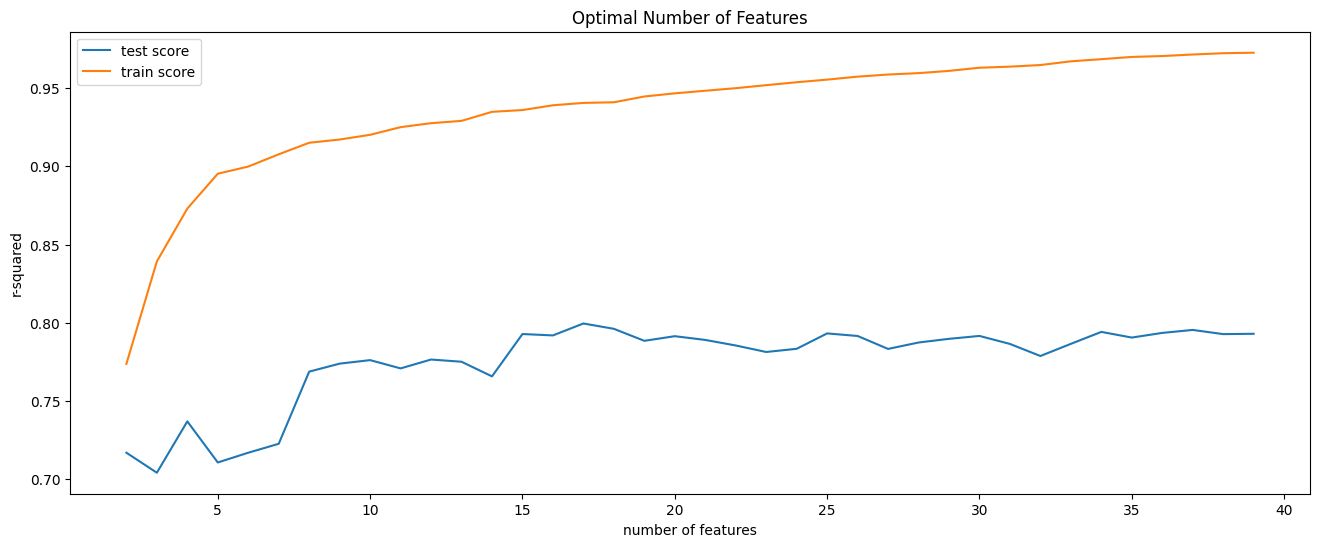

In [100]:
# plotting cv results
plt.figure(figsize=(16,6))

plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'], loc='upper left')